# Machine learning and a microbiome dataset

*Giovanni Birolo and Andrea Telatin*

Importing in Python a typical microbiome dataset, exploring its content and using
statistical and machine learning libraries to classify and predict labels.


In [1]:
# Import relevant libraries
import numpy
import pandas

## A typical microbiome dataset

A microbiome dataset, derived from 16S or WGS profiling, typically comprises several tables (or Data Frames) that include:

* **Metadata**, which contains a comprehensive set of attributes for each sample.
* **Feature table**, detailing the abundance of each feature (a proxy for "species") in every sample.
* **Taxonomy table**, outlining the taxonomic classification for each feature.

For this workshop we will analyse [a dataset](https://pubmed.ncbi.nlm.nih.gov/22688727/) from Pat Schloss lab: a metabarcoding study of the 
murine gut microbiome, to track daily fecal sample community membership and structure from individual mice over the first year of life.

The study identified two distinct community states within this period, with the latter state demonstrating greater stability and no correlation with taxonomic or phylogenetic diversity, suggesting a significant degree of microbiome stability post-transition.

### The metadata

Let's start importing the metadata.

In [2]:
# Load metadata as dataframe
sample_df = pandas.read_csv('mouse-16s/metadata.csv', index_col=0)
#  and view it
sample_df

,Sex,Individual,Day,Label
#NAME,,,,
Mock2,M,M0,0,Early
F3D0,F,F3,0,Early
F3D1,F,F3,1,Early
F3D11,F,F3,11,Early
F3D125,F,F3,125,Late
...,...,...,...,...
M6D6,M,M6,6,Early
M6D65,M,M6,65,Early
M6D7,M,M6,7,Early


The metadata table consists of four columns (attributes), of which "Label" is the main attribute used in the paper: it's a categorization of the
column "Day", which is the "Day after weaning" column.

We can organize the data in `sample_df` by grouping it based on different 'Label' categories. 
For each group of labels, we will then looks at the 'Day' column and provides a summary. 
This summary includes statistics like the count of entries, the average (mean), minimum, maximum values, 
and some percentile values (like the 25th, 50th, and 75th percentiles) for the days associated with each label. 

Essentially, it's a way to quickly understand how the days are distributed across different labels in the dataset.

In [3]:
sample_df.groupby('Label')['Day'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
Early,214.0,13.864486,15.800854,0.0,4.0,8.5,17.0,65.0
Late,147.0,159.285714,54.685652,124.0,143.0,146.0,149.0,364.0


We can now remove the 'Individual' column from the `sample_df` data table and 
then counts how often each unique combination of values occurs in the remaining data.

In [4]:
sample_df.drop('Individual', axis=1).value_counts()

Sex  Day  Label
M    0    Early    7
     364  Late     6
F    1    Early    6
     0    Early    6
M    141  Late     6
                  ..
F    364  Late     3
     165  Late     2
M    124  Late     2
F    124  Late     1
     302  Late     1
Name: count, Length: 67, dtype: int64

### The feature table

We can similarily import the feature table.

In [5]:
otu_df = pandas.read_csv('mouse-16s/otutab.tsv', sep='\t', index_col=0)
otu_df

,F6D7,M3D21,F7D13,M2D13,F8D7,M5D3,M3D17,M6D146,M3D19,M6D6,...,F3D8,M3D0,F7D0,F3D0,F8D3,M4D125,M4D142,F5D0,M6D15,F4D142
#OTU ID,,,,,,,,,,,,,,,,,,,,,
seq_1,860,1489,796,1411,440,1884,842,359,589,1069,...,304,875,880,617,1273,915,1270,1813,887,1066
seq_2,1007,1627,942,946,504,644,716,394,530,990,...,364,829,1221,374,905,661,912,1309,576,1106
seq_3,804,1864,1513,935,650,672,1169,328,557,592,...,365,1196,748,481,542,210,580,1510,454,879
seq_4,193,1101,346,879,91,460,971,570,435,174,...,155,1776,110,473,122,856,1616,1353,265,811
seq_5,908,314,944,679,644,566,432,306,544,966,...,621,1977,179,186,1078,411,557,2192,866,651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
seq_380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
seq_383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can transpose the feature table (also called OTU table). 

This is often done to make the samples (previously columns) now rows, 
which is a common format for machine learning and statistical analyses where features (OTUs in this case) 
need to be columns and each row represents an observation or sample.

In [6]:
# We can transpose the dataframe to easily match the metadata
transposed_otu_df = otu_df.T

Now we can select rows from `sample_df` where the index (row labels) matches the index of X, the transposed otu_df. 

This ensures that the samples in Y are in the same order as in X, 
aligning the metadata or measurements in sample_df with the corresponding OTU data in X. 

This alignment is crucial for subsequent analyses, ensuring that each row across X and Y corresponds to the same sample.

In [7]:
aligned_sample_df = sample_df.loc[transposed_otu_df.index]

## Visual exploration (unsupervised)

We will now visualise the sample similarity with a PCA. It's important to notice that
there are measures of the "distance" of samples based on ecological concepts (such as [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index)),
and some are even designed for microbiome compositions (like the [UniFrac](https://en.wikipedia.org/wiki/UniFrac)).

To focus on the general procedure (*i.e.* applicable on other datasets too) we will simplify the problem and just use the logarithm of counts.


In [8]:
# Let's import PCA from Scikit Leaern and Seaborn (a plotting library)
from sklearn.decomposition import PCA
import seaborn

Now we can apply a logarithmic transformation to the data in `transposed_otu_df`, 
adding 1 before taking the log to avoid the issue of taking the logarithm of zero (which is undefined). 

This transformation is commonly used in data preprocessing to handle skewed data or data spanning several orders of magnitude, 
typical in OTU (Operational Taxonomic Units) abundances or other biological data.

In [9]:
log_transposed_otu_df = numpy.log10(transposed_otu_df + 1)

PCA reduces the data from many dimensions (variables) to just two main components (PC1 and PC2) that capture the most important patterns in the data. 

This is done after log transforming and transposing the original data, which likely makes the data more suitable for 
PCA by normalizing the distribution and aligning samples as rows. 

The resulting two main components are stored in a new table with the same sample identifiers (index) as the original data and two columns named 'PC1' and 'PC2'.

In [10]:
pca_df = pandas.DataFrame(PCA(2).fit_transform(log_transposed_otu_df), index=log_transposed_otu_df.index, columns=['PC1', 'PC2'])
pca_df = pandas.concat([pca_df, aligned_sample_df], axis=1)

We can now plot the data from `pca_df` with 'PC1' values on the x-axis and 'PC2' values on the y-axis,
and colors the points based on different categories found in the '**Label**' (Early or Late) column to visually distinguish between them.

<Axes: xlabel='PC1', ylabel='PC2'>

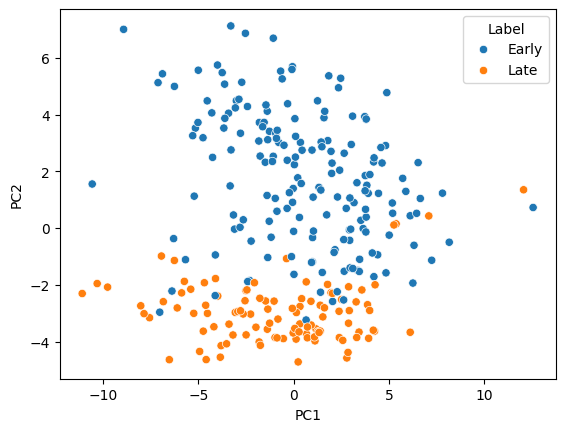

In [11]:
seaborn.scatterplot(pca_df, x='PC1', y='PC2', hue='Label')

The microbiome seems very distinct in the two categories. 

Is the microbiome also associated with the sex of the mouse?

<Axes: xlabel='PC1', ylabel='PC2'>

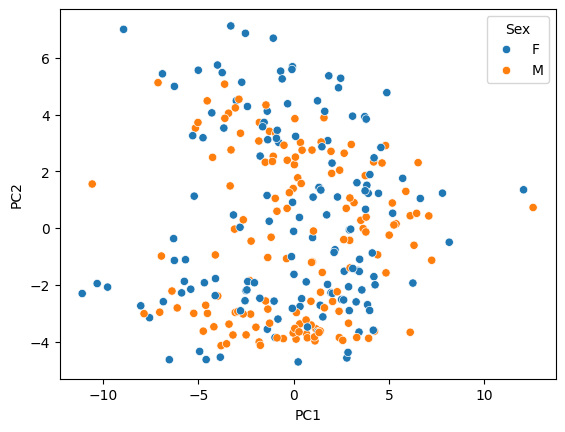

In [12]:
seaborn.scatterplot(pca_df, x='PC1', y='PC2', hue='Sex')

From our graphical exploration, it doesn't look so.

## A statistical test

We can use the [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)
to determine significant differences between two independent groups across various features. 

The method involves calculating p-values for each feature to assess the likelihood of observing 
the current data under the null hypothesis—that the distributions of both groups are identical. 

These p-values are compiled and sorted to identify features with significant disparities between groups, 
offering a clear insight into the data's underlying structure without delving into specific variable names or technical details.

In [13]:
from scipy.stats import mannwhitneyu

In [14]:
pandas.Series({
    name: mannwhitneyu(*x.groupby(aligned_sample_df['Label']).agg(list)).pvalue
    for name, x in transposed_otu_df.items()
}).sort_values()

seq_137    2.087308e-40
seq_109    4.223526e-38
seq_19     2.982987e-32
seq_249    1.518142e-28
seq_215    5.514011e-28
               ...     
seq_289    9.670333e-01
seq_381    9.684301e-01
seq_330    9.794577e-01
seq_335    9.885374e-01
seq_226    9.944515e-01
Length: 387, dtype: float64

Each representative sequence (OTU or ASV...) is associated with a p-value, 
indicating the statistical significance of the difference between two groups for that particular sequence.

The p-values range from extremely small (e.g., 2.087308e-40 for seq_137) to values close to 1 (e.g., 0.9944515 for seq_226), 
sorted in ascending order. 

Smaller p-values suggest strong evidence against the null hypothesis, implying significant differences between the groups for those sequences. 
In contrast, p-values near 1 indicate little to no evidence against the null hypothesis, suggesting no significant difference between the groups for those sequences.

## Supervised approach

In this section, we explore the application of machine learning to our dataset using a **Random Forest Classifier**
(see our previous [workshop by Dipali Singh](https://drive.google.com/drive/folders/1UY6pvTyzaAuNIgJfXMwIWCEBryKdcVdb).

Note that we will use two *labels*:
* "Label" (can be "Early" or "Late)
* "Sex" (can be "Male" or "Female")

As we noticed, there is a clear separation among *Early* and *Late* samples.

In [15]:
from sklearn.model_selection import cross_val_score, GroupKFold, KFold
from sklearn.ensemble import RandomForestClassifier

In [16]:
y_label = sample_df.loc[transposed_otu_df.index, 'Label']
y_sex = sample_df.loc[transposed_otu_df.index, 'Sex']
individual = sample_df.loc[transposed_otu_df.index, 'Individual']

Predicting on the training set

In [17]:
RandomForestClassifier(random_state=0).fit(log_transposed_otu_df, y_label).score(log_transposed_otu_df, y_label)

1.0

Impressive, or "too good to be true"?

### Splitting Data for Training and Testing

Following the initial model evaluation, we proceed to split our dataset into training and testing sets using the `train_test_split` method. 
This crucial step divides the dataset into separate parts: one for training the Random Forest Classifier and another for testing its performance on unseen data. 

The shape attributes of `X_train` and `X_test` are examined to understand the distribution of data between the training and testing phases.
Subsequently, a new Random Forest Classifier is trained on the training set and its accuracy is evaluated on the test set. 

This process not only validates the model's ability to generalize to new data but also provides insights into its predictive accuracy, helping identify potential overfitting or underfitting issues.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(log_transposed_otu_df, y_label)
# Let's see the "shape" of these tables
X_train.shape, X_test.shape

((211, 387), (71, 387))

The first pair (211, 387) refers to the size of the **training dataset** (X_train). 
It means that there are 211 samples or rows, and each sample has 387 features or columns. This is the larger portion of the dataset and is used to train or teach the model.

The second pair (71, 387) refers to the size of the **testing dataset** (X_test). 
It indicates that there are 71 samples or rows, and like the training set, each sample has 387 features or columns. This portion of the dataset is used to test or evaluate how well the model has learned from the training dataset.

In [20]:
RandomForestClassifier(random_state=0).fit(X_train, y_train).score(X_test, y_test)

0.9577464788732394

### Repeated train-test split


In the next section, we conduct an experiment to further assess the performance of our model. By repeating the process of dividing our dataset into training and testing sets ten times, we train and test a Random Forest Classifier on each new split. For each iteration, we note the model's accuracy score on the test data, providing us with ten separate evaluations.

In this way we have a more accurate estimate of the performance of the model.

In [22]:
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(log_transposed_otu_df, y_label)
    accuracy = RandomForestClassifier(random_state=0).fit(X_train, y_train).score(X_test, y_test)
    scores.append(accuracy)
scores

[0.971830985915493,
 0.9436619718309859,
 0.9436619718309859,
 0.9577464788732394,
 0.9859154929577465,
 0.9577464788732394,
 0.9577464788732394,
 0.9577464788732394,
 0.971830985915493,
 0.971830985915493]

It's important to observe the variability: if we only assess the accuracy once, we can get a misleading number out of a specific training set.

After completing these iterations, we train another Random Forest Classifier on the entire dataset and assess its accuracy in predicting a specific outcome (indicated by y_sex). 

This final step helps us understand how well the model performs when trained and evaluated on the same data, offering a comparison point to the earlier cross-validation results.

In [23]:
print(f"Mean accuracy = {numpy.mean(scores):.3f} ± {numpy.std(scores):.3f}")

Mean accuracy = 0.962 ± 0.013


### A prediction on another variable: sex


In [24]:
RandomForestClassifier(random_state=0).fit(log_transposed_otu_df, y_sex).score(log_transposed_otu_df, y_sex)

1.0

#### Sex bias?

What is the difference of the cross validation if we do it randomly or controlling the sex variable?

In this step, we apply the `cross_val_score` function to assess the overall performance of the Random Forest Classifier across multiple subsets of the dataset. 

This function divides the dataset (X and y) into several distinct folds, trains the model on some of these folds, and tests it on the remaining ones. 

This process is repeated multiple times, each time with a different set of folds as the training and testing sets. 
The aim is to evaluate the model's effectiveness in a more robust and less biased way than using a single train-test split. 
The scores from each iteration are then averaged to produce a mean score, which provides a comprehensive measure of the model's accuracy across different parts of the dataset. 
By setting `random_state=0`, we ensure that the splitting of the dataset into folds is consistent across different runs, making the evaluation process reproducible and reliable.

In [26]:
# Label (Early/Late)
cross_val_score(RandomForestClassifier(random_state=0), log_transposed_otu_df, y_label).mean()

0.9679824561403508

In [27]:
# Sex
cross_val_score(RandomForestClassifier(random_state=0), log_transposed_otu_df, y_sex).mean()

0.90062656641604

In these steps, we're enhancing the evaluation of the Random Forest Classifier by incorporating a grouping factor into our cross-validation process, specifically using [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) cross-validation. 

This method is particularly useful when the dataset contains multiple observations from the same group or individual, 
and you want to ensure that data from the same group is not split across both training and testing sets. 

This helps to prevent data leakage and ensures that the model's performance is evaluated in a way that more accurately reflects its ability to generalize to entirely new groups or individuals.

In [28]:
cross_val_score(RandomForestClassifier(), log_transposed_otu_df, y_label, groups=individual, cv=GroupKFold()).mean()

0.9357221479500891

> We use sex to show how the training accuracy can be overestimated

Finally we can assess our model controlling not only for sex, but also for individual (we observe the same individual multiple times, hence if we randomly split the training and test dataset we will "see" again in the test.

As we can see, the score drops to 68%.

In [29]:
cross_val_score(RandomForestClassifier(), log_transposed_otu_df, y_sex, groups=individual, cv=GroupKFold()).mean()

0.6740282976827094

### Continuous Outcome Prediction

In this section, we delve into predictive modeling for continuous outcomes using the `RandomForestRegressor`,
focusing on predicting the 'Day' variable from our dataset. 
Initially, we fit and assess the model's performance directly on our data, targeting the continuous '**Day**' variable as our prediction goal (i.e. number of days after wheaning, that was previously used as a categorical label Early/Late).

To validate our model's accuracy and generalizability, we employ two cross-validation strategies: [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn-model-selection-kfold) and [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html). 

* The KFold method provides a basic evaluation by partitioning the data into folds for systematic training and testing. To address the challenge of repeated observations from the same individuals, we then apply GroupKFold. 
* GroupKFold ensures that all data from an individual is either in the training set or the testing set, offering a more realistic assessment of the model’s performance on entirely new data.

These steps aim to refine our understanding of the RandomForestRegressor’s predictive capability, especially in a context where the independence of observations is crucial for accurate model evaluation.

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Extract the 'Day' column from 'sample_df' for rows that match the index of 'log_transposed_otu_df' as the target variable.
y_day = sample_df.loc[log_transposed_otu_df.index, 'Day']

Create a RandomForestRegressor, fit it to the data, and then calculate and return the coefficient of determination (R^2) of the prediction.

In [31]:
RandomForestRegressor().fit(log_transposed_otu_df, y_day).score(log_transposed_otu_df, y_day)

0.9704632885284774

Perform cross-validation using a RandomForestRegressor, returning the mean score of the cross-validated groups with **KFold** cross-validator (cv=).

In [32]:
cross_val_score(RandomForestRegressor(), log_transposed_otu_df, y_day, groups=individual, cv=KFold()).mean()

0.7896287622886529

Perform cross-validation using a RandomForestRegressor, but with the **GroupKFold** cross-validator to take into account groupings specified by 'individual'.

In [33]:
cross_val_score(RandomForestRegressor(), log_transposed_otu_df, y_day, groups=individual, cv=GroupKFold()).mean()

0.7955677741593228

Are we good enough in predicting the variable?

The improvement in the score from KFold to GroupKFold (from 0.7965 to 0.8098) suggests that accounting for groupings within your data leads to a more accurate model. 
This is likely because GroupKFold prevents information leakage between the training and testing sets by ensuring that data from the same group (e.g., the same individual) are all in either the training set or the testing set but not split across both.
 